# Hybrid Multimodal Urban Routes

The focus of this activity is to evaluate the impacts of using Hybrid Urban Routing to a set trips identified in the city of São Paulo using the Twitter API. We collected geo-located tweets, anonymized them and in the present experiment we will cluster these tweets in order to identify trip flows. After this identification of flows we will evaluate the impacts in terms of price, duration and walking distance in the trips in case they were performed using hybrid routing.

## Record Linkage

The first step consists in linking the individual tweets into trips. To do so we will link all time-sequenced tweets from the same user and take them as trips. After this initial linkage, some filters are applied in order to keep only valid trips. For example, we consider valid trips only trips started and finished in the same day, bounded between 2 Km/h and 100 Km/h. Other filters were also used in the following code.


In [2]:
import os
import pandas as pd
from haversine import haversine

directory = 'data/anonym/'
file = 'twitter-sao-paulo.csv'

df = pd.read_csv(directory + file)
print('raw size: %d' % len(df))

if file == 'twitter-sp.csv':
    df['layer'] = 'twitter_sp'

df = df.sort_values(by=['uid', 'timestamp'], ascending=True)
df = pd.concat([df.add_suffix('_departure'), df.shift(-1).add_suffix('_arrival')], axis=1)

df = df[df.uid_departure == df.uid_arrival]
print('user links filtered: %d' % len(df))

df['day_diff'] = df.apply(lambda r: abs(int(r.timestamp_arrival / 24 / 60 / 60) - int(r.timestamp_departure / 24 / 60 / 60)), axis=1)
df = df[df.day_diff == 0]
print('same day filtered: %d' % len(df))

df['distance'] = df.apply(lambda r: haversine((r.lat_departure, r.lon_departure), (r.lat_arrival, r.lon_arrival)), axis=1)
df = df[df.distance > 0.1]
print('length filtered: %d' % len(df))

df = df[df.timestamp_arrival > df.timestamp_departure]
print('0s filtered: %d' % len(df))

df['speed'] = df.apply(lambda r: r.distance / (r.timestamp_arrival - r.timestamp_departure) * 60 * 60, axis=1)
df = df[(df.speed > 2) & (df.speed < 100)]
print('speed filtered: %d' % len(df))

# formating
df.drop(['layer_arrival', 'uid_arrival', 'day_diff'], axis=1, inplace=True)
df.rename({'layer_departure': 'layer', 'uid_departure': 'uid'}, axis=1, inplace=True)

if not os.path.exists('data/trips/'):
    os.makedirs('data/trips/')
df.to_csv('data/trips/' + file, index=False)

raw size: 690139
user links filtered: 588760
same day filtered: 94411
length filtered: 40612
0s filtered: 40567
speed filtered: 15675


## Clustering

Once the trips were linked, the next objective is to cluster the main flows in those trips. This is done due to the long time taken to evaluate routes. Using the main flows we can have an idea of the impacts of the hybrid routing without computing every route in the dataset.

In this step we use the [SMAFramework](https://github.com/diegopso/smaframework), a urban mobility analisys tool. This framework counts with an algorithm to identify main flows in a trip dataset. The algorithm uses HDBSCAN algorithm to identify functional departure and arraival zones in the dataset; after it computes the flows between those zones and classify them in trending or secondary. 

The output is produced using Google Maps API, thus some keys must be configurated. In this section only Google Maps API is used, however we will configure all the keys. To do so, create a file called `.env` at the root of the project containing the API keys, like:


```
UBER_SERVER_TOKEN=your-key-here
GOOGLE_MAPS_KEY=your-key-here
TOMTOM_KEY=your-key-here
```



In [3]:
from smaframework.common.env import env
import smaframework.analyzer.clustering.flow as FlowClusterer

if not os.path.exists('data/results/'):
    os.makedirs('data/results/')

directory = 'data/trips/'
FlowClusterer.cluster_hdbscan(directory + file, ['lat_departure', 'lon_departure'], ['lat_arrival', 'lon_arrival'], output_file='data/results/%s' % file[0:-4], gmaps_key=env('GOOGLE_MAPS_KEY'), min_size=5)

INFO: running HDBSCAN
INFO: finished HDBSCAN with nclusters(origin=827, destination=834)
INFO: flow_thershold=28.000000 for file=data/results/twitter-sao-paulo


,flow,lat_arrival,lat_departure,lon_arrival,lon_departure
1453,65,-23.636980,-23.451383,-46.560042,-46.642510
1456,54,-23.519881,-23.451383,-46.680803,-46.642510
1636,76,-23.451423,-23.636992,-46.642496,-46.560095
1638,32,-23.565010,-23.636992,-46.626663,-46.560095
1639,60,-23.519881,-23.636992,-46.680803,-46.560095
1650,44,-23.558154,-23.627975,-46.608289,-46.555166
2844,63,-23.451423,-23.519865,-46.642496,-46.680793
2845,61,-23.636980,-23.519865,-46.560042,-46.680793
2846,52,-23.565010,-23.519865,-46.626663,-46.680793
2910,47,-23.636980,-23.565065,-46.560042,-46.626571


You can check the [Map Output](/view/data/results/twitter-sao-paulo.html) to visualize the flows identified.

## Routing

In this step, still making use of the SMAFramework to aid us, we will compute the routes for those flows. The idea is to combine routes to avoid traffic congestions, thus we will first compute a Driving Route for the flows using the [TomTom Routing API](https://developer.tomtom.com/), this API provide us some information abou the traffic conditions that can be used to improve the path. After collecting the driving ways we will compute the hybrid routes avoiding congested areas. To compute the routes we will use [Uber](https://developer.uber.com/) and [Google Directions](https://developers.google.com/maps/documentation/directions/start) API.

In [4]:
import json, datetime
import smaframework.extractor.tomtom.router as TomTomRouter
import smaframework.extractor.uber as UberExtractor
import smaframework.extractor.google.directions as GoogleDirectionsExtractor

def route(start, end):
    # transit pricing
    prices = {'TRANSIT': 4.25}

    # get driving way with traffic information
    driving_ways = TomTomRouter.getRoute(start, end, env('TOMTOM_KEY'), 0, True, False)
    
    # for each requested option
    for way in driving_ways:
        if 'sections' not in way.keys() or 'section' not in way['sections'].keys():
            continue

        # combine section to cover all traffic-avoidance options
        sections = way['sections']['section']
        if len(sections) > 0:
            combined_sections = []
            for (i, s1) in enumerate(sections):
                for (j, s2) in enumerate(sections):
                    if i >= j:
                        continue

                    combined_sections.append({
                      "sectionType": "TRAFFIC",
                      "effectiveSpeedInKmh": (float(s1['effectiveSpeedInKmh']) + float(s2['effectiveSpeedInKmh'])) / 2,
                      "delayInSeconds": s1['delayInSeconds'] + s2['delayInSeconds'],
                      "magnitudeOfDelay": max(s1['magnitudeOfDelay'], s2['magnitudeOfDelay']),
                      "effectiveSpeed": (s1['effectiveSpeed'] + s2['effectiveSpeed']) / 2,
                      "startPoint": s1['startPoint'],
                      "endPoint": s2['endPoint']
                    })
            sections.extend(combined_sections)

        # for each section with traffic, get some hybrid options
        options = []
        for section in sections:
            # evaluate an HPV started option
            transition = (section['startPoint']['@latitude'], section['startPoint']['@longitude'])
            estimate = UberExtractor.estimate(env('UBER_SERVER_TOKEN'), start, transition, 1, 'UberX')
            estimate['travel_mode'] = 'UberX'
            transit = GoogleDirectionsExtractor.extract_single(env('GOOGLE_MAPS_KEY'), transition, end, datetime.datetime.now(), 'transit', prices)
            option = [estimate]
            option.extend(transit[0])
            options.append(option)

            # evaluate an HPV ended option
            transition = (section['endPoint']['@latitude'], section['endPoint']['@longitude'])
            transit = GoogleDirectionsExtractor.extract_single(env('GOOGLE_MAPS_KEY'), start, transition, datetime.datetime.now(), 'transit', prices)
            estimate = UberExtractor.estimate(env('UBER_SERVER_TOKEN'), transition, end, 1, 'UberX')
            estimate['travel_mode'] = 'UberX'
            option = [estimate]
            option.extend(transit[0])
            options.append(option)

    full_hpv = [UberExtractor.estimate(env('UBER_SERVER_TOKEN'), start, end, 1, 'UberX')]
    full_hpv[0]['travel_mode'] = 'UberX'
    full_transit = GoogleDirectionsExtractor.extract_single(env('GOOGLE_MAPS_KEY'), start, end, datetime.datetime.now(), 'transit', prices)[0]
    options.extend([full_hpv, full_transit])
    
    return options
    
flows = json.load(open('data/results/twitter-sao-paulo.json', 'r+'))

for (i, flow) in enumerate(flows):
    start = (flow['link'][0]['lat'], flow['link'][0]['lng'])
    end = (flow['link'][1]['lat'], flow['link'][1]['lng'])
    flow['options'] = route(start, end)
    print('Options for flow %d computed.' % (i+1))

json.dump(flows, open('data/results/options.json', 'w+'))

Options for flow 1 computed.
Options for flow 2 computed.
Options for flow 3 computed.
Options for flow 4 computed.
Options for flow 5 computed.
Options for flow 6 computed.
Options for flow 7 computed.
Options for flow 8 computed.
Options for flow 9 computed.
Options for flow 10 computed.
Options for flow 11 computed.
Options for flow 12 computed.


All the options were evaluated and saved to the `data\results` folder.

## Ploting Impact

With the options in hand it is possible to evalute their average impact. The impact represents the gain/loss in terms of Price, Duration and Walking Distance in trips using UberX, Public Transportation or Hybrid options.

<IPython.core.display.Javascript object>


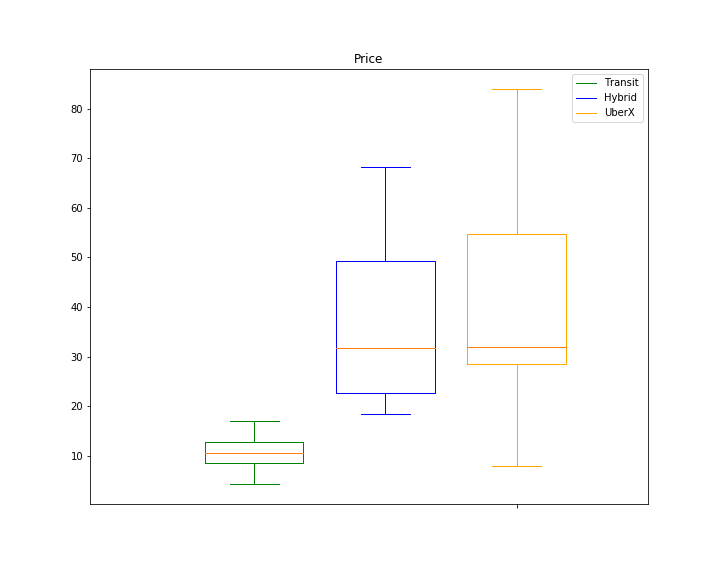

<IPython.core.display.Javascript object>


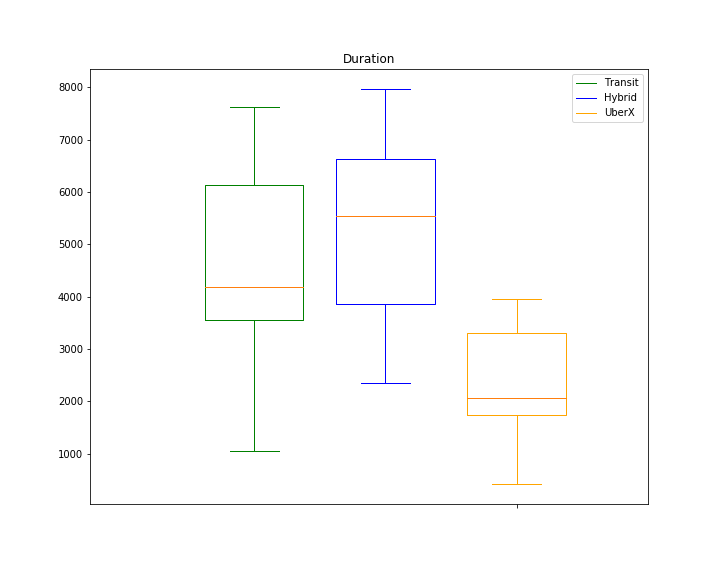

<IPython.core.display.Javascript object>


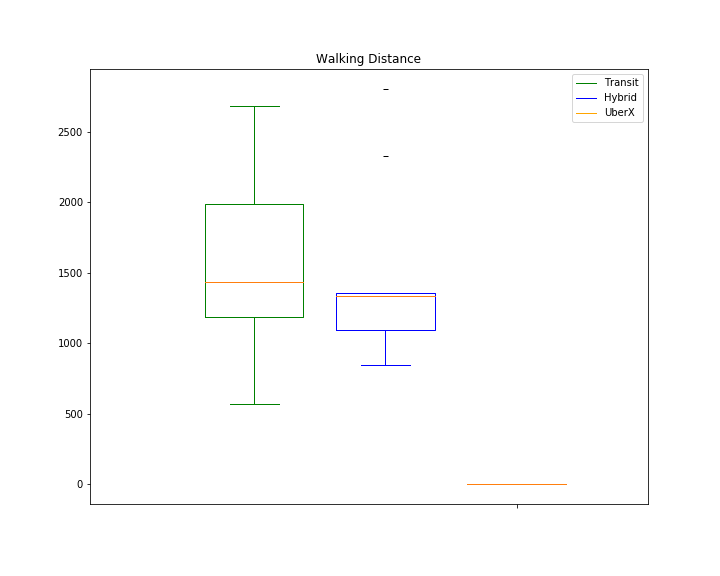

In [15]:
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt

options = []
flows = json.load(open('data/results/options.json', 'r+'))
for flow in flows:
    for option in flow['options']:
        price = 0
        modes = set()
        duration = 0
        walking_distance = 0
        drop = False
        
        for step in option:
            if 'price' not in step.keys():
                drop = True
                break
                
            price += step['price']
            duration += step['duration']
            modes.add(step['travel_mode'])
            if step['travel_mode'] == 'WALKING':
                walking_distance += step['distance']

        if drop:
            continue
                
        mode = 'WALKING'
        if any(mode == 'UberX' for mode in modes) and any(mode != 'UberX' for mode in modes):
            mode = 'HYBRID'
        elif any(mode == 'TRANSIT' for mode in modes):
            mode = 'TRANSIT'
        elif all(mode == 'UberX' for mode in modes):
            mode = 'UberX'

        options.append({
            'price': price,
            'mode': mode,
            'duration': duration,
            'walking_distance': walking_distance
        })

df = pd.DataFrame(options)
columns = ['effective_cost', 'effective_cost_perceived', 'effective_cost_norm', 'effective_cost_perceived_norm', 'traversed_distance', 'duration', 'perceived_duration', 'cost', 'walking_distance', 'congested_time', 'wait', 'weight']

hybrid = df[df['mode'] == 'HYBRID']
taxi = df[df['mode'] == 'UberX']
transit = df[df['mode'] == 'TRANSIT']

plot_columns = ['price', 'duration', 'walking_distance']
titles = {'price': 'Price', 'duration': 'Duration', 'walking_distance': 'Walking Distance'}

for c in plot_columns:
    p = 1
    fig, ax = plt.subplots(ncols=1, figsize=(10, 8))

    bplot1 = ax.boxplot(transit[c].as_matrix(), positions=[p], flierprops={'marker': '_', 'markersize': 5}, boxprops={'color':'green'}, whiskerprops={'color':'green'}, capprops={'color':'green'})
    bplot2 = ax.boxplot(hybrid[c].as_matrix(), positions=[p + .2], flierprops={'marker': '_', 'markersize': 5}, boxprops={'color':'blue'}, whiskerprops={'color':'blue'}, capprops={'color':'blue'})
    bplot3 = ax.boxplot(taxi[c].as_matrix(), positions=[p + .4], flierprops={'marker': '_', 'markersize': 5}, boxprops={'color':'orange'}, whiskerprops={'color':'orange'}, capprops={'color':'orange'})

    plt.title(titles[c])
    ax.legend([bplot1["boxes"][0], bplot2["boxes"][0], bplot3["boxes"][0]], ['Transit', 'Hybrid', 'UberX'], loc='upper right')
    ax.set_xticklabels([])

    plt.xlim((0.75, p + .6))
    plt.show()
    plt.figure(1)

## Discussion and Final Remarks

The experiment were condcted with a very limited dataset and lead to the results shown. The results in terms of prices were expected, the hybrid option lays between the Public Transport and the Uber options. However, the results obtained in terms of duration were not encouraging, since hybrid options actually took longer than the Public Transport. It may be justified by saying that hybrid trips had a smaller walking distance compared to trips performed only in Public Transportation.

Similar experiments were performed in the city of New York, where also User Experience variables were added to evaluate the impact of hybrid urban routing. The results there were slightly more appealing than the ones obtained here. It may also be related to the larger dataset used and some other conditions of the experiment. The interested audience may check these results in the paper [Hybrid Context-Aware Multimodal Routing](https://doi.org/10.1109/ITSC.2018.8570008).